# Results correlation analysis

In [3]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scripts.utils as utils
plot_kwargs = {'bbox_inches': "tight", 'dpi': 200}

config = utils.load_config("scripts")
tempdir = config['paths']['tempdir']
indir = config['paths']['resultsdir']
outdir = config['paths']['resultsdir']
figdir = config['paths']['figdir']


RZ_IDS = [*gpd.read_file(os.path.join(tempdir, "wrz_buffer.gpkg"))['RZ_ID'].unique()]
INDICATOR = "ep"
SCENARIOS = ["BS", "NF", "FF"]
INDICATORS = ['ep_total', 'ep_mean', 'q50_anomaly_total', 'q75_anomaly_total', 'q90_anomaly_total', 'q50_deficit_total']

In [4]:
# get correlations for every variable with the LoS severity and save to dataframe
for RZ_ID in RZ_IDS:
    dfs = []
    for scenario in SCENARIOS:
        datadir = os.path.join(indir, scenario.lower(), "events")
        datapath = os.path.join(datadir, f"wrz_{RZ_ID}.csv")
        if os.path.exists(datapath):
            dfs.append(pd.read_csv(datapath))
    if len(dfs) > 0:
        df_wrz = pd.concat(dfs)

        corr_dfs = []
        for indicator in INDICATORS:
            corrs = {}
            pvals = {}
            for buffer in df_wrz['buffer'].unique():
                df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
                buffer = int(buffer)
                for backcast in df_wrz['backcast'].unique():
                    df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
                    corr, pval = spearmanr(df_wrz_buffer_backcast[indicator], df_wrz_buffer_backcast['severity'])
                    corrs[(buffer, backcast)] = [corr]
                    pvals[(buffer, backcast)] = [pval]

            corrs_df = pd.DataFrame(corrs).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: f'{indicator}_r'})
            pvals_df = pd.DataFrame(pvals).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: f'{indicator}_p'})
            corrs_df[f'{indicator}_p'] = pvals_df[f'{indicator}_p']
            corrs_df = corrs_df.set_index(['buffer', 'backcast'])
            corr_dfs.append(corrs_df)

        corrs_df = pd.concat(corr_dfs, axis=1).reset_index()
        corrs_df.to_csv(os.path.join(outdir, 'correlations', f'wrz_{RZ_ID}.csv'), index=False)
    else:
        print(f"No dataframes found for WRZ {RZ_ID}")

No dataframes found for WRZ 69
No dataframes found for WRZ 91
No dataframes found for WRZ 101


30


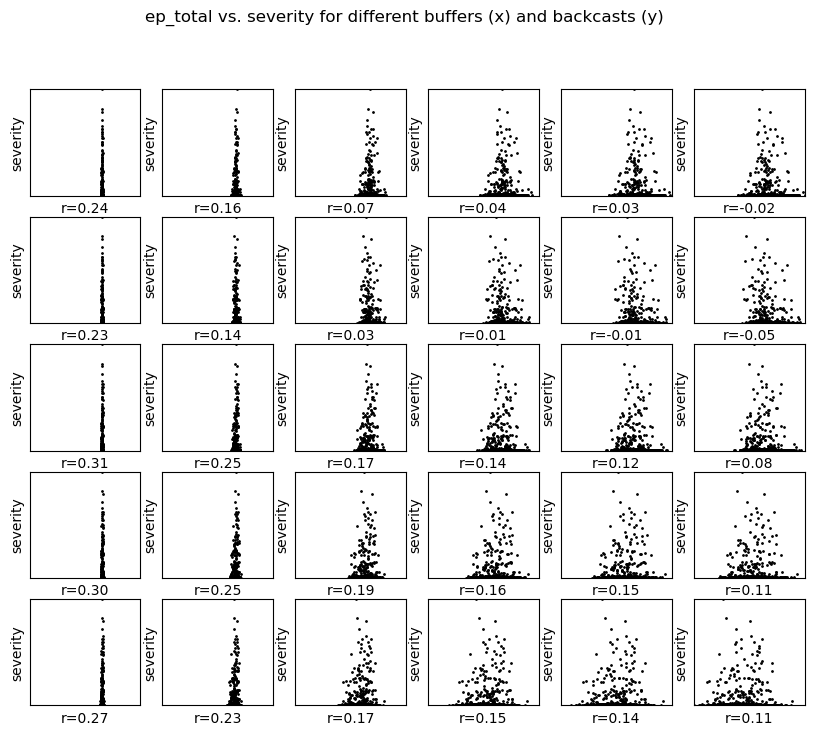

In [5]:
# create scatter plots for different buffer sizes/backcasts for each WRZ
all_df = pd.concat(dfs)
indicator = 'ep_total'
xmin = all_df[indicator].min()
xmax = all_df[indicator].max()
ymax = all_df['severity'].max()

backcasts = all_df['backcast'].unique()
buffers = all_df['buffer'].unique()
print(len(backcasts) * len(buffers))
fig, axs = plt.subplots(len(backcasts), len(buffers), figsize=(10, 8))
for i, backcast in enumerate(backcasts):
    for j, buffer in enumerate(buffers):
        df_sub = all_df[all_df['buffer'] == buffer].copy()
        df_sub = df_sub[df_sub['backcast'] == backcast].copy()
        
        axs[i, j].scatter(df_sub[indicator], df_sub['severity'], s=1, color='k')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlabel(f"r={spearmanr(df_sub[indicator], df_sub['severity'])[0]:.2f}")
        axs[i, j].set_xlim([xmin, xmax])
        axs[i, j].set_ylim([0, ymax])
        axs[i, j].set_ylabel('severity')

fig.suptitle(f"{indicator} vs. severity for different buffers (x) and backcasts (y)");
fig.savefig(os.path.join(figdir, 'correlations', f'scatterplot_{indicator}.png'), **plot_kwargs)

In [6]:
# create correlation heatmaps for different buffer sizes/backcasts for eac WRZ
def plot_heatmap(RZ_ID, indicator, outdir, **heatmap_kwargs):
    corrs_df_wrz = pd.read_csv(os.path.join(outdir, 'correlations', f'wrz_{RZ_ID}.csv'))
    corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_r', index='buffer', columns='backcast').transpose()
    pvals_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_p', index='buffer', columns='backcast').transpose()
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', **heatmap_kwargs)
    
    for y in range(corrs_df_wrz_pivoted.shape[0]):
        for x in range(corrs_df_wrz_pivoted.shape[1]):
            ax.text(x, y, '%.2f' % pvals_df_wrz_pivoted.iloc[y, x],
             horizontalalignment='center',
             verticalalignment='center',
          )
            
    ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
    ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
    ax.set_ylabel('Backcast (months)')
    ax.set_xlabel('Buffer radius (km)')
    ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. Severity")
    ax.invert_yaxis()
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Spearman correlation')
    
    fig.suptitle(f"WRZ {RZ_ID}")
    return fig


for RZ_ID in RZ_IDS:
    for indicator in INDICATORS:
        fig = plot_heatmap(1, indicator, outdir)
        if not os.path.exists(os.path.join(figdir, 'correlations', f"{RZ_ID}")):
            os.makedirs(os.path.join(figdir, 'correlations', f"{RZ_ID}"))
        fig.savefig(os.path.join(figdir, 'correlations', f"{RZ_ID}", f"{indicator}.png"), **plot_kwargs)
        plt.close()

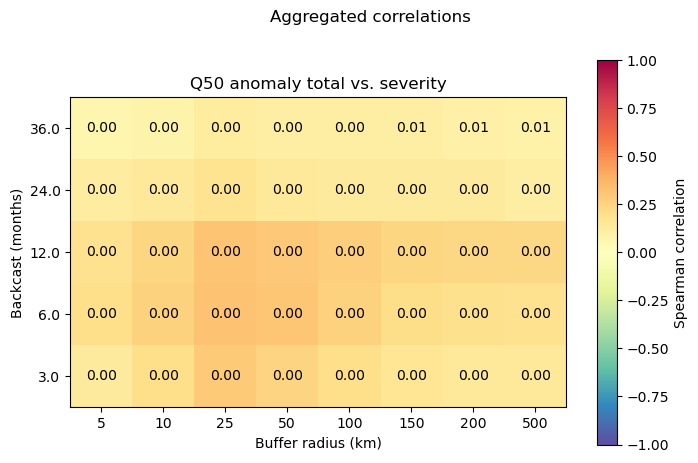

In [6]:
# create correlation heatmaps for different buffer sizes/backcasts over all WRZs
def plot_heatmap2(corrs_df_wrz, indicator):
    corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_r', index='buffer', columns='backcast').transpose()
    pvals_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_p', index='buffer', columns='backcast').transpose()
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', vmin=-1, vmax=1)
    
    for y in range(corrs_df_wrz_pivoted.shape[0]):
        for x in range(corrs_df_wrz_pivoted.shape[1]):
            ax.text(x, y, '%.2f' % pvals_df_wrz_pivoted.iloc[y, x],
             horizontalalignment='center',
             verticalalignment='center',
          )
            
    ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
    ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
    ax.set_ylabel('Backcast (months)')
    ax.set_xlabel('Buffer radius (km)')
    ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. severity")
    ax.invert_yaxis()
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Spearman correlation')
    
    fig.suptitle(f"Aggregated correlations")
    return fig


import glob
dfs = []
all_corr_csvs = glob.glob(os.path.join(outdir, 'correlations', f'wrz_*.csv'))

for csv in all_corr_csvs:
    dfs.append(pd.read_csv(csv))

    
all_corr_dfs = pd.concat(dfs, axis=0)

# get statistics
mean_corrs = all_corr_dfs.groupby(['buffer', 'backcast']).mean().reset_index()
median_corrs = all_corr_dfs.groupby(['buffer', 'backcast']).median().reset_index()


fig = plot_heatmap2(median_corrs, 'q50_anomaly_total')